# Prediciendo El Rating De Las Aplicaciones En Google Play Store

### Descripción

El mercado de las aplicaciones móviles cada vez es más competitivo y entender que variables pueden favorecer a la hora de diseñar dichas aplicaciones puede ser de gran ayuda en la toma de decisiones de negocio.  

El objetivo de esta competencia será analizar y clasificar el rating de las aplicaciones móviles en el mercado Android de Google Play Store. 


### Dataset

El conjunto de datos contiene características principales de las aplicaciones en el mercado de Google Play Store. 

Definición de variables:

#### ID  = Identificador único de la aplicación
#### App  = Nombre de la aplicación
#### Category  =  Categoría de la aplicación 
#### Reviews = Numero de reseñas de la aplicación 
#### Size  = Tamaño de la aplicación 
#### Installs  = Numero de descargas/instalaciones en el equipo
#### Type = Gratis (Free) o Paid (Paga)
#### Price  = Precio de la aplicación en dólares
#### Content rating = Calificación de contenido
#### Genres = Géneros
#### Last Updated = Ultimo día de actualización 
#### Current Ver = Versión actual de la aplicación 
#### Android Ver = Versión de Android requerida
#### Rating = Calificación de la aplicación 

# Loading & Exploring the Data Structure

Cargue de librerias

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from time import time

from math import sqrt
import statsmodels.api as sm
from statsmodels.formula.api import ols
import scipy.stats as st
from scipy.special import boxcox1p

from sklearn.cluster import KMeans
from sklearn import svm
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import RobustScaler, LabelEncoder, StandardScaler
from sklearn.linear_model import Lasso, Ridge
from sklearn.pipeline import make_pipeline
from xgboost.sklearn import XGBClassifier

Cargue de datasets

In [2]:
train = pd.read_csv("../data/Train.csv")
test = pd.read_csv("../data/Test.csv")

In [3]:
print("Dimensions of Train Dataset:" + str(train.shape))
print("Dimensions of Test Dataset:" + str(test.shape))

Dimensions of Train Dataset:(5788, 14)
Dimensions of Test Dataset:(1448, 13)


In [4]:
train['Rating'].unique()

array([1., 0.])

In [5]:
train.iloc[:,0:18].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5788 entries, 0 to 5787
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ID              5788 non-null   int64  
 1   App             5788 non-null   object 
 2   Category        5788 non-null   object 
 3   Rating          5788 non-null   float64
 4   Reviews         5788 non-null   int64  
 5   Size            5788 non-null   object 
 6   Installs        5788 non-null   object 
 7   Type            5788 non-null   object 
 8   Price           5788 non-null   object 
 9   Content Rating  5788 non-null   object 
 10  Genres          5788 non-null   object 
 11  Last Updated    5788 non-null   object 
 12  Current Ver     5788 non-null   object 
 13  Android Ver     5788 non-null   object 
dtypes: float64(1), int64(2), object(11)
memory usage: 633.2+ KB


A continuación, vamos a definir algunas variables que se utilizarán en análisis posteriores, además de ser necesarias para el archivo de envío.

In [6]:
y_train = train['Rating']
test_id = test['ID']

#Tamaño de los datasets
ntrain = train.shape[0]
ntest = test.shape[0]

ahora vamos a combinar la base train y test para explorar los datos e imputar los valores faltantes.

In [7]:
all_data = pd.concat((train, test), sort=True).reset_index(drop=True)
all_data['Dataset'] = np.repeat(['Train', 'Test'], [ntrain, ntest], axis=0)
all_data.drop('ID', axis=1,inplace=True)

# Exploring the Variables

## Exploracion variable de respuesta

Dado que es un ranking normalmente debería ser una variable continua (1 - 5) sin embargo esat variable solo tiene 1 y 0

# Data Imputation


Completitud de los datos

Solo encontramos que los datos de Rating del data frame Test son las faltantes, de resto no hay datos faltantes

In [8]:
cols_with_missing_values = all_data.isnull().sum().sort_values(ascending=False)
display(pd.DataFrame(cols_with_missing_values[cols_with_missing_values[cols_with_missing_values > 0].index], 
                     columns=["Number of Missing Values"]))

,Number of Missing Values
Rating,1448


# Feature Engineering

In [9]:
all_data.head()

,Android Ver,App,Category,Content Rating,Current Ver,Genres,Installs,Last Updated,Price,Rating,Reviews,Size,Type,Dataset
0,4.0 and up,GPS Status & Toolbox,TRAVEL_AND_LOCAL,Everyone,8.1.171,Travel & Local,"10,000,000+","June 13, 2018",0,1.0,149723,4.1M,Free,Train
1,4.1 and up,Fish|Hunt FL,LIFESTYLE,Everyone,3.2.0,Lifestyle,"100,000+","March 22, 2018",0,0.0,853,34M,Free,Train
2,Varies with device,Allrecipes Dinner Spinner,FOOD_AND_DRINK,Everyone,Varies with device,Food & Drink,"5,000,000+","April 10, 2018",0,1.0,61881,Varies with device,Free,Train
3,2.3 and up,Don't touch my phone,TOOLS,Everyone,30,Tools,"5,000,000+","October 19, 2016",0,0.0,21943,2.3M,Free,Train
4,4.1 and up,BM SPM Practice,FAMILY,Everyone,1.0,Education,"1,000+","January 24, 2018",0,1.0,6,9.2M,Free,Train


### Android Ver

Vamos a crear dos columnas nuevas, la primera es la versión minima de android, la segunda la versión maxima

In [10]:
#version minima 
all_data['Ver Min'] =  pd.to_numeric(all_data['Android Ver'].str[:3], errors='coerce') 

In [11]:
#Reemplazamos por la mediana
all_data['Ver Min'].fillna(all_data['Ver Min'].median(), inplace=True)

In [12]:
#version maxima
all_data['Ver Max'] = all_data['Android Ver'].str[-5:]

In [13]:
all_data['Ver Max'].unique()

array(['nd up', 'evice', '7.1.1', '- 8.0', '- 6.0'], dtype=object)

In [14]:
all_data['Ver Max'] = all_data['Ver Max'].replace('7.1.1', '7.1')
all_data['Ver Max'] = all_data['Ver Max'].replace('- 8.0', '8.0')
all_data['Ver Max'] = all_data['Ver Max'].replace('- 6.0', '6.0')
all_data['Ver Max'] = all_data['Ver Max'].replace('nd up', '9.0') #Version vigente para la fecha del data frame

In [15]:
#Convertimos en numerica
all_data['Ver Max'] =  pd.to_numeric(all_data['Ver Max'].str[:3], errors='coerce') 

In [16]:
#Reemplazamos por la mediana
all_data['Ver Max'].fillna(all_data['Ver Max'].median(), inplace=True)

In [17]:
#Eliminamos la variable de version original

all_data.drop(['Android Ver'], axis=1, inplace=True)

### Category

In [18]:
Category_agrup =  all_data[['Category', 'Rating']].groupby(['Category']).agg(['mean', 'count'])

In [19]:
Category_agrup.columns = ['mean', 'count']
Category_agrup.reset_index(inplace=True)

In [20]:
#Category_agrup.sort_values(by=['mean'], ascending=False)

In [21]:
R_by_category =  all_data[all_data['Dataset'] == 'Train'].groupby(['Category']).mean()

In [22]:
R_by_category.reset_index(level=0, inplace=True)

In [23]:
R_by_category.drop(['Reviews', 'Ver Min', 'Ver Max'], axis=1, inplace=True)

In [24]:
R_by_category.columns = ['Category', 'Rating_cat']

In [25]:
all_data = pd.merge(all_data, R_by_category[['Category', 'Rating_cat']], left_on= ['Category'], right_on=['Category'], how = 'left')

In [26]:
#Eliminamos la variable de version original

all_data.drop(['Category'], axis=1, inplace=True)

### Genres

In [27]:
all_data.columns

Index(['App', 'Content Rating', 'Current Ver', 'Genres', 'Installs',
       'Last Updated', 'Price', 'Rating', 'Reviews', 'Size', 'Type', 'Dataset',
       'Ver Min', 'Ver Max', 'Rating_cat'],
      dtype='object')

In [28]:
a = all_data['Genres'].str.split(";", n = 1, expand = True)

In [29]:
a.columns = ['Genre_1', 'Genre_2']

In [30]:
all_data['Genres'] = a['Genre_1']

In [31]:
R_by_Genre =  all_data[all_data['Dataset'] == 'Train'].groupby(['Genres']).sum()

In [32]:
R_by_Genre.reset_index(level=0, inplace=True)

In [33]:
R_by_Genre.drop(['Reviews', 'Ver Min', 'Ver Max', 'Rating_cat'], axis=1, inplace=True)

In [34]:
R_by_Genre.columns = ['Genres', 'Rating_Gen']

In [35]:
all_data = pd.merge(all_data, R_by_Genre[['Genres', 'Rating_Gen']], left_on= ['Genres'], right_on=['Genres'], how = 'left')

In [36]:
all_data.drop(['Genres'], axis=1, inplace=True)

## Last Update

In [37]:
all_data['Last Updated']  = all_data['Last Updated'] = pd.to_datetime(all_data['Last Updated'])

In [38]:
all_data['Last Updated_days']  = all_data['Last Updated'] .max() - all_data['Last Updated']

In [39]:
all_data['Last Updated_days'] = all_data['Last Updated_days'].apply(lambda x: x.days)

In [40]:
all_data.drop(['Last Updated'], axis=1, inplace=True)

## Installs

In [41]:
all_data['Installs'] = all_data['Installs'].str.replace(r'\D', '')

In [42]:
all_data['Installs'] = all_data['Installs'].astype(float)

## Price

In [43]:
all_data['Price'] = all_data['Price'].str.replace(r'$', '')

In [44]:
all_data['Price'] = all_data['Price'].astype(float)

## Size

In [45]:
all_data['Size_a'] = all_data['Size'].str[-1:]

In [46]:
all_data['Size_a'] = all_data['Size_a'].replace('e', np.NaN)
all_data['Size_a'] = all_data['Size_a'].replace('M', 1000000)
all_data['Size_a'] = all_data['Size_a'].replace('k', 1000)

In [47]:
all_data['Size_a'].unique()

array([1000000.,      nan,    1000.])

In [48]:
all_data['Size'] = all_data['Size'].str.replace(r'[aA-zZ]+', '')

In [49]:
all_data['Size'] =  pd.to_numeric(all_data['Size'], errors='coerce') 
all_data['Size_a'] =  pd.to_numeric(all_data['Size_a'], errors='coerce') 

In [50]:
all_data['Size'] =  all_data['Size'] * all_data['Size_a'] 

In [51]:
all_data['Size'] = all_data['Size'].fillna(all_data['Size'].mean())

In [52]:
all_data.drop(['Size_a'], axis=1, inplace=True)

## Current Ver

In [53]:
all_data['Current Ver'] = all_data['Current Ver'].str.replace(r'[aA-zZ]+', '')

In [54]:
a = all_data['Current Ver'].str.split(".", n = 4, expand = True)

In [55]:
a.columns = ['Version', 'Sub_ver', 'Sub_ver_2', 'Sub_ver_3', 'Sub_ver_4']

In [56]:
a = a.fillna(0)

In [57]:
#a['Version'] = a['Version'].astype(int)
#a['Sub_ver'] = a['Sub_ver'].astype(int)
#a['Sub_ver_2'] = a['Sub_ver_2'].astype(int)

In [58]:
#all_data['Current_Ver_exp'] = a['Version']*a['Sub_ver']*a['Sub_ver_2']

In [59]:
#all_data['Current_Ver'] = all_data['Current_Ver'].fillna(all_data['Current_Ver'].median())

In [60]:
all_data['Current_Ver'] = a['Version']
#all_data['Current_Ver_2'] = a['Sub_ver']

In [61]:
#Convertimos en numerica
all_data['Current_Ver'] =  pd.to_numeric(all_data['Current_Ver'], errors='coerce') 
#all_data['Current_Ver_2'] =  pd.to_numeric(all_data['Current_Ver'], errors='coerce') 

In [62]:
all_data['Current_Ver'] = all_data['Current_Ver'].replace(0, np.NaN)

In [63]:
all_data['Current_Ver'] = all_data['Current_Ver'].apply(lambda x: np.where(x > 15,np.nan,x))
all_data['Current_Ver'] = all_data['Current_Ver'].apply(lambda x: np.where(x < 0,np.nan,x))

In [64]:
train_Current_Ver = all_data[~all_data.Current_Ver.isnull()]
test_Current_Ver = all_data[all_data.Current_Ver.isnull()]

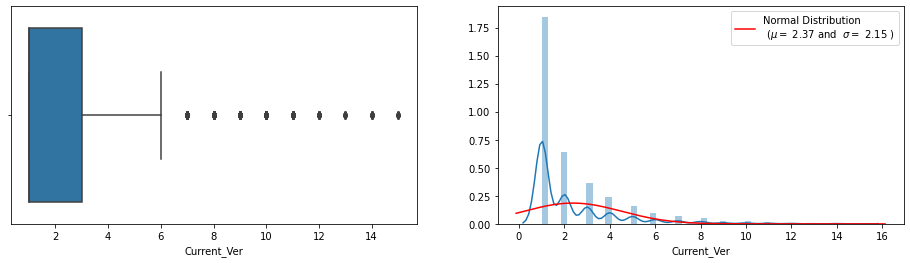

In [65]:
fig, ax = plt.subplots(1,2, figsize=(16,4))
sns.boxplot(train_Current_Ver['Current_Ver'], ax=ax[0])

sns.distplot(train_Current_Ver['Current_Ver'], ax=ax[1], fit=st.norm, fit_kws={"color":"red"})
(mu, sigma) = st.norm.fit(train_Current_Ver['Current_Ver'])
plt.legend(['Normal Distribution \n ($\mu=$ {:.2f} and  $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best', fancybox=True)
plt.show()

In [66]:
all_data['Current_Ver'] = all_data['Current_Ver'].fillna(all_data['Current_Ver'].median())

In [67]:
all_data.drop(['Current Ver'], axis=1, inplace=True)

In [68]:
all_data['Type'] = all_data['Type'].replace('Free', 0)
all_data['Type'] = all_data['Type'].replace('Paid', 1)
all_data['Type'] = all_data['Type'].astype(int)

In [69]:
all_data.columns

Index(['App', 'Content Rating', 'Installs', 'Price', 'Rating', 'Reviews',
       'Size', 'Type', 'Dataset', 'Ver Min', 'Ver Max', 'Rating_cat',
       'Rating_Gen', 'Last Updated_days', 'Current_Ver'],
      dtype='object')

In [70]:
all_data['Rev_install'] = all_data['Reviews'] / all_data['Installs']   

In [71]:
#all_data['Reviews_year'] = all_data['Reviews'] / all_data['Last Updated_days']   
#all_data['Reviews_year'] = all_data['Reviews_year'].fillna(0)

all_data['Rev_install'] = all_data['Rev_install'].fillna(0)

#all_data['Reviews_year'] =  all_data['Reviews_year'].replace(-np.inf, np.nan)

#all_data['Rev_install'] = all_data['Rev_install'].fillna(0)

In [72]:
#from numpy import inf
#all_data['Reviews_year'] [all_data['Reviews_year']  == inf] = 0

In [73]:
#all_data.max()

In [74]:
all_data.columns

Index(['App', 'Content Rating', 'Installs', 'Price', 'Rating', 'Reviews',
       'Size', 'Type', 'Dataset', 'Ver Min', 'Ver Max', 'Rating_cat',
       'Rating_Gen', 'Last Updated_days', 'Current_Ver', 'Rev_install'],
      dtype='object')

# Skewness & Normalization of Numeric Variables

In [75]:
numeric_feats = ['Installs', 'Price', 'Reviews', 'Size', 'Rating_cat', 'Rating_Gen', 'Last Updated_days', 'Current_Ver', 'Rev_install']

skewed_feats = all_data[numeric_feats].apply(lambda x: st.skew(x.dropna())).sort_values(ascending=False)
skewness = pd.DataFrame({'Skew Before Transformation' :skewed_feats})

skewness = skewness[abs(skewness) > 1].dropna(axis=0)
skewed_features = skewness.index
for feat in skewed_features:
    all_data[feat] = np.log1p(all_data[feat]+1)

skewed_feats = all_data[skewed_features].apply(lambda x: st.skew(x.dropna())).sort_values(ascending=False)
skewness['Skew After Transformation'] = skewed_feats
skewness

,Skew Before Transformation,Skew After Transformation
Reviews,26.794373,0.125382
Price,25.663991,6.991071
Rev_install,20.747723,11.477539
Installs,15.219577,-0.238070
Current_Ver,2.559536,1.515706
Last Updated_days,2.222751,-0.057082
Size,1.785258,-0.981077


In [76]:
all_data.drop(['App', 'Reviews'], axis=1, inplace=True)

In [77]:
all_data.drop(['Type'], axis=1, inplace=True)

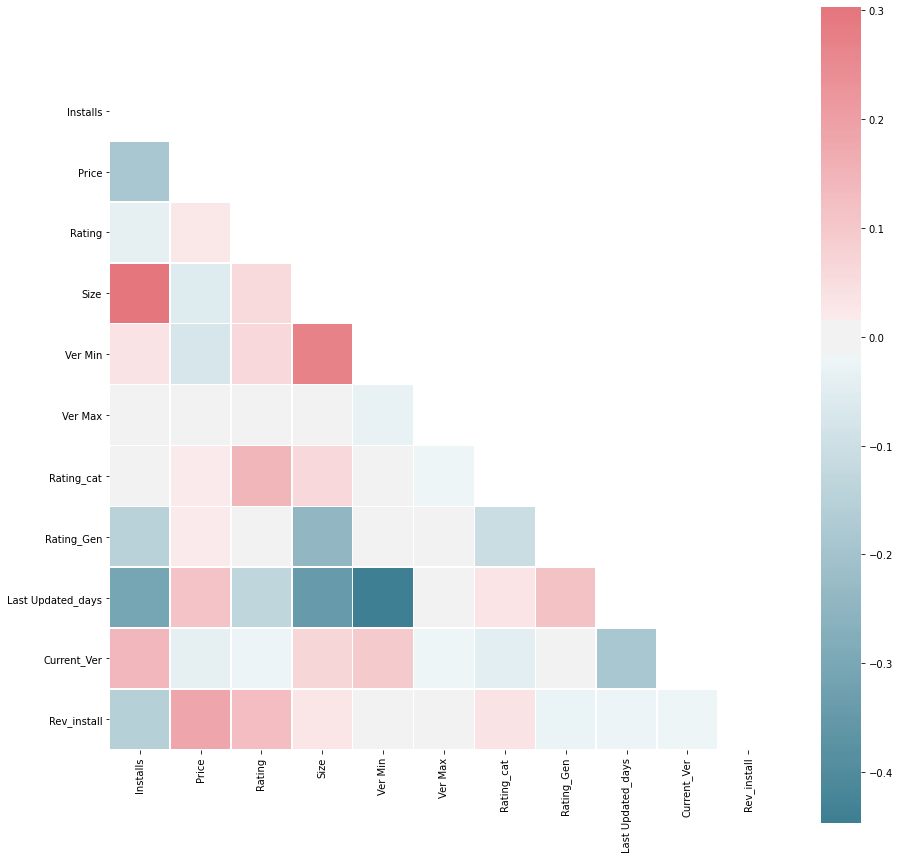

In [78]:
corr = all_data.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(15, 15))
cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap,
            center=0, square=True, linewidths = .5)
plt.show()

In [79]:
all_data = pd.get_dummies(all_data)
print(all_data.shape)
all_data.head(3)

(7236, 19)


,Installs,Price,Rating,Size,Ver Min,Ver Max,Rating_cat,Rating_Gen,Last Updated_days,Current_Ver,Rev_install,Content Rating_Adults only 18+,Content Rating_Everyone,Content Rating_Everyone 10+,Content Rating_Mature 17+,Content Rating_Teen,Content Rating_Unrated,Dataset_Test,Dataset_Train
0,16.118096,0.693147,1.0,15.226498,4.0,9.0,0.699248,93.0,4.060443,2.302585,0.700605,0,1,0,0,0,0,0,1
1,11.512945,0.693147,0.0,17.341871,4.1,9.0,0.657534,144.0,4.948760,1.609438,0.697403,0,1,0,0,0,0,0,1
2,15.424949,0.693147,1.0,16.817655,4.0,9.0,0.731343,49.0,4.804021,1.098612,0.699316,0,1,0,0,0,0,0,1


In [80]:
all_data_bal = all_data[~all_data['Rating'].isnull()]

In [81]:
# Class count
count_class_0, count_class_1 = all_data_bal.Rating.value_counts()

# Divide by class
df_class_0 = all_data_bal[all_data_bal['Rating'] == 0]
df_class_1 = all_data_bal[all_data_bal['Rating'] == 1]

In [82]:
df_class_0_under = df_class_1.sample(count_class_1, random_state = 1111)
all_data_under = pd.concat([df_class_0_under, df_class_0], axis=0)

In [83]:
all_data_under[~all_data_under['Rating'].isnull()].groupby("Rating").size()

Rating
0.0    1471
1.0    1471
dtype: int64

In [84]:
final_y_train = all_data_under['Rating'][~all_data_under['Rating'].isnull()]
final_X_train = all_data_under[all_data_under['Dataset_Train'] == 1].drop(['Dataset_Train', 'Dataset_Test', 'Rating'], axis=1)


final_X_test = all_data[all_data['Dataset_Test'] == 1].drop(['Dataset_Train', 'Dataset_Test', 'Rating'], axis=1)

# XGBoost

In [85]:
xg_X_train, xg_X_test, xg_y_train, xg_y_test = train_test_split(final_X_train, final_y_train, test_size=0.33, random_state=1234)

xg_model = XGBClassifier(n_estimators=100, seed = 1234)
param_dict = {'max_depth': [2, 3,4],
              'min_child_weight': [4, 5, 6],
              'learning_rate': [0.1,0.15, 0.2],
              'gamma': [0.0, 0.01, 0.05],
              'colsample_bytree':[0.5, 0.7, 1]
}

start = time()
grid_search = GridSearchCV(xg_model, param_dict)
grid_search.fit(xg_X_train, xg_y_train)
print("GridSearch took %.2f seconds to complete." % (time()-start))
display(grid_search.best_params_)

In [86]:
xg_model = XGBClassifier(n_estimators = 1000,
                        learning_rate = 0.1,
                        max_depth = 3,
                        min_child_weight = 4,
                        gamma = 0.01,
                        colsample_bytree = 0.5, 
                        seed = 1234,
                        eval_metric = 'auc')

In [87]:
from sklearn.metrics import accuracy_score

In [88]:
start = time()
xg_model.fit(xg_X_train, xg_y_train)
xg_preds = xg_model.predict(xg_X_test)
print("Model took %.2f seconds to complete." % (time()-start))
print(accuracy_score(xg_y_test, xg_preds))

Model took 1.17 seconds to complete.
0.6652935118434603


In [89]:
e = xg_model.predict_proba(xg_X_test)

prob_xg = pd.DataFrame(e, columns=['prob_1', 'prob_0']) 

Confusion matrix:
 [[338 150]
 [175 308]]


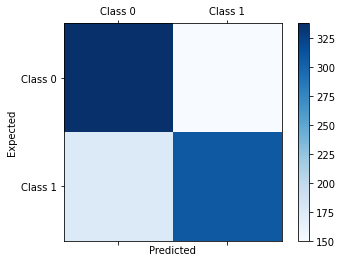

In [90]:
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt

conf_mat = confusion_matrix(y_true=xg_y_test, y_pred=xg_preds)
print('Confusion matrix:\n', conf_mat)

labels = ['Class 0', 'Class 1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

AUC: 0.665


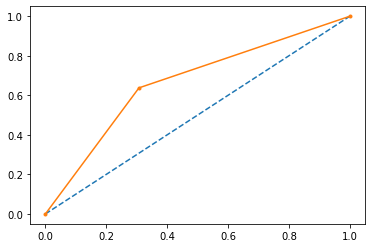

In [91]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

auc = roc_auc_score(xg_y_test, xg_preds)
print('AUC: %.3f' % auc)
# calculate roc curve
fpr, tpr, thresholds = roc_curve(xg_y_test, xg_preds)
# plot no skill
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
pyplot.plot(fpr, tpr, marker='.')
# show the plot
pyplot.show()

In [92]:
for x in range(len(final_X_train.columns)):
  xg_model.get_booster().feature_names[x] = final_X_train.columns[x]

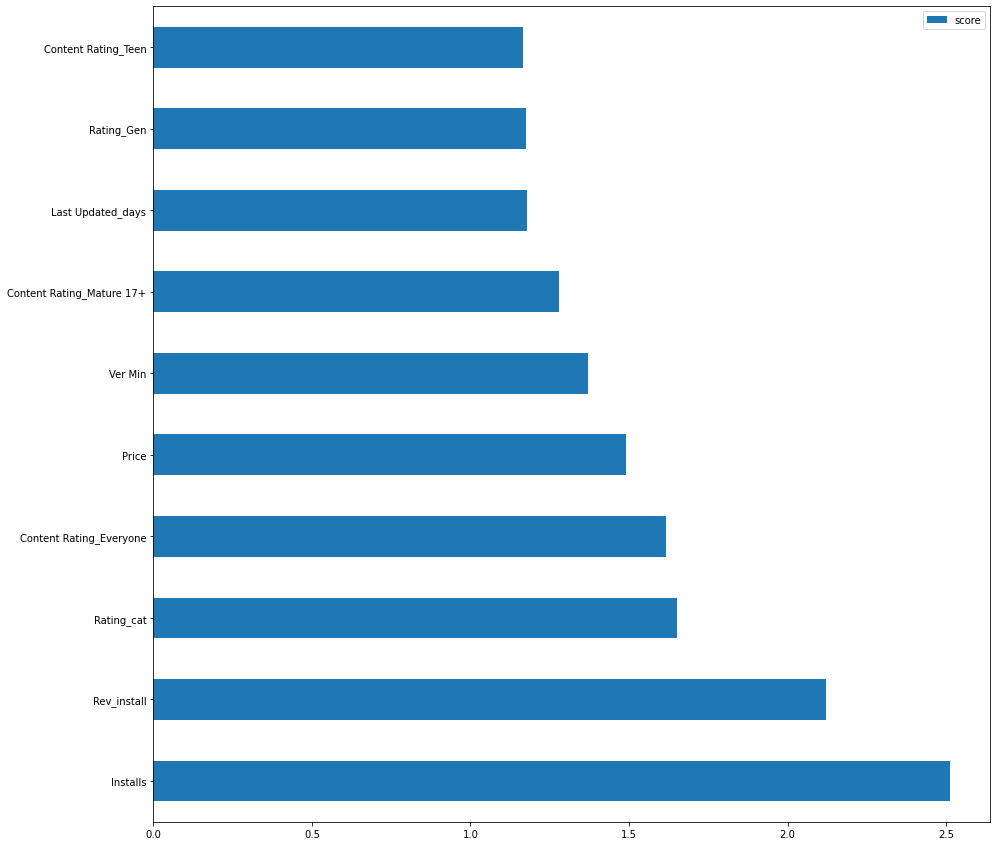

In [93]:
from xgboost import plot_importance

feature_important = xg_model.get_booster().get_score(importance_type='gain')
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data = data.head(10)

f, ax = plt.subplots(figsize =(15, 15)) 
data.plot(kind='barh', ax = ax)

# Random Forest

In [94]:
from sklearn.ensemble import RandomForestClassifier
rclf = RandomForestClassifier()

In [95]:
rclf.fit(xg_X_train,xg_y_train)

RandomForestClassifier()

In [96]:
#best_random = rf_random.best_estimator_
brf= rclf.predict(xg_X_test)

print(accuracy_score(xg_y_test, brf))

0.6910401647785788


In [97]:
from sklearn.metrics import accuracy_score,recall_score,confusion_matrix
rf_y_pred = brf
print(len(xg_y_test))
print(accuracy_score(xg_y_test,rf_y_pred))
#print(recall_score(xg_y_test,y_pred))
#print(confusion_matrix(xg_y_test,y_pred))

971
0.6910401647785788


AUC: 0.691


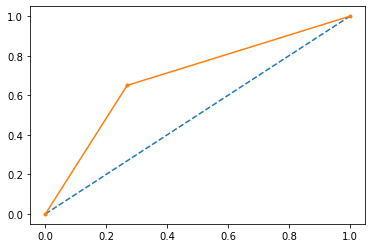

In [98]:
auc = roc_auc_score(xg_y_test, rf_y_pred)
print('AUC: %.3f' % auc)
# calculate roc curve
fpr, tpr, thresholds = roc_curve(xg_y_test, rf_y_pred)
# plot no skill
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
pyplot.plot(fpr, tpr, marker='.')
# show the plot
pyplot.show()

# LGBM

In [99]:
import lightgbm as lgb
d_train = lgb.Dataset(xg_X_train, label=xg_y_train)
params = {}
params['learning_rate'] = 0.003
params['boosting_type'] = 'gbdt'
params['objective'] = 'binary'
params['metric'] = 'auc'
params['sub_feature'] = 0.5
params['num_leaves'] = 10
params['min_data'] = 50
params['max_depth'] = 10
clf = lgb.train(params, d_train, 100)

[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 988, number of negative: 983
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000777 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 871
[LightGBM] [Info] Number of data points in the train set: 1971, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501268 -> initscore=0.005074
[LightGBM] [Info] Start training from score 0.005074


In [100]:
#Prediction
y_pred_lg=clf.predict(xg_X_test)
#convert into binary values
for i in range(0,len(y_pred_lg)):
    if y_pred_lg[i]>=.5:       # setting threshold to .5
       y_pred_lg[i]=1
    else:  
       y_pred_lg[i]=0

AUC: 0.698


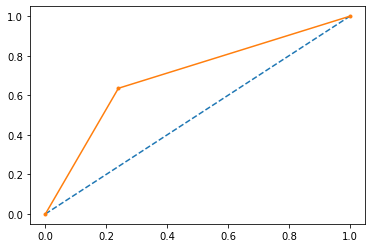

In [101]:
auc = roc_auc_score(xg_y_test, y_pred_lg)
print('AUC: %.3f' % auc)
# calculate roc curve
fpr, tpr, thresholds = roc_curve(xg_y_test, y_pred_lg)
# plot no skill
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
pyplot.plot(fpr, tpr, marker='.')
# show the plot
pyplot.show()

# Modelo de ensamble

In [102]:
xg_preds = xg_model.predict(xg_X_test)
rf_preds = rclf.predict(xg_X_test)
lg_preds=y_pred_lg

In [103]:
df_total = pd.DataFrame(xg_preds, columns=['pred_xg']) 
df_total['pred_rf'] = pd.DataFrame(rf_preds, columns=['pred_rf']) 
df_total['pred_lg'] = pd.DataFrame(lg_preds, columns=['pred_lg']) 

In [104]:
df_total['Final'] = df_total['pred_xg']*(1/3) + df_total['pred_rf']*(1/3) + df_total['pred_lg']*(1/3)

In [105]:
#Prediction
y_pred_en= df_total['Final'] 
#convert into binary values
for i in range(0,len(y_pred_en)):
    if y_pred_en[i]>=.5:       # setting threshold to .5
       y_pred_en[i]=1
    else:  
       y_pred_en[i]=0

AUC: 0.695


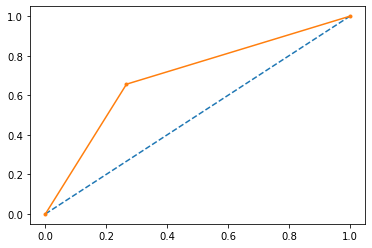

In [106]:
auc = roc_auc_score(xg_y_test, y_pred_en)
print('AUC: %.3f' % auc)
# calculate roc curve
fpr, tpr, thresholds = roc_curve(xg_y_test, y_pred_en)
# plot no skill
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
pyplot.plot(fpr, tpr, marker='.')
# show the plot
pyplot.show()

# Predicción

In [107]:
xg_preds = xg_model.predict(final_X_test)
rf_preds = rclf.predict(final_X_test)
lg_preds=clf.predict(final_X_test)

In [108]:
#convert into binary values
for i in range(0,len(lg_preds)):
    if lg_preds[i]>=.5:       # setting threshold to .5
       lg_preds[i]=1
    else:  
       lg_preds[i]=0

In [109]:
df_total = pd.DataFrame(xg_preds, columns=['pred_xg']) 
df_total['pred_rf'] = pd.DataFrame(rf_preds, columns=['pred_rf']) 
df_total['pred_lg'] = pd.DataFrame(lg_preds, columns=['pred_lg']) 

In [115]:
df_total['Final'] = df_total['pred_xg']*(1/4) + df_total['pred_rf']*(1/2) + df_total['pred_lg']*(1/4)

In [116]:
#Prediction
xg_preds= df_total['Final'] 
#convert into binary values
for i in range(0,len(xg_preds)):
    if xg_preds[i]>=.5:       # setting threshold to .5
       xg_preds[i]=1
    else:  
       xg_preds[i]=0

In [117]:
sub = pd.DataFrame()
sub['id'] = test_id
sub['rating'] = xg_preds

In [118]:
sub.to_csv('../data/Submission_i.csv', index=False)